This notebook will test a variety of evaluation methods for STF versus STL, STR, and possibly other decompositions. 

In [210]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.tsatools import freq_to_period
import math
import warnings
import copy
from statsmodels.tsa.seasonal import STL
from statsmodels.datasets import elec_equip as ds
import statsmodels.datasets

warnings.filterwarnings("ignore")
class STF_reflected:

    # init method or constructor 
    def __init__(self, data, window, period = None, pad = None, seasonal = None):
        self.data = data
        self.window = window
        if period is None:
            freq = None
            if isinstance(data, (pd.Series, pd.DataFrame)):
                freq = getattr(data.index, 'inferred_freq', None)
            if freq is None:
                raise ValueError("Unable to determine period from data")
            period = freq_to_period(freq)
        self.period = period
        self._observed = data
        self.pad = pad

    def fit(self):
        
        dt = 1 / (self.period)
        t = np.array(self.data.index)

        f = np.array(self.data.squeeze())
        half = np.floor(len(t)/2)
        # Reflect f onto f on both tails
        reflected = np.append(np.flip(f), f)
        reflected = np.append(reflected, np.flip(f))
        
        self.observed = pd.Series(self.data.squeeze(), self.data.index)

 

        n = len(reflected)
        #Compute FFT
        fhat = np.fft.fft(reflected, n)
        fhat_seasonal = copy.copy(fhat)
        

        if self.window == "tukey":
            window = signal.tukey(len(reflected), alpha = self.pad)
        else:
            window = get_window(self.window, len(reflected))
        
        # X axis of freqs
        freq = (1 / (dt*n)) * np.arange(n)

        # Apply window to freqs
        freq = freq*window

        # Filter freqs for trend (low pass filter)
        filter_cutoff = (2*math.pi) / (n)
        filter_cutoff = ((self.period)/(n*2*math.pi*10)) 
        #filter_cutoff = (2*math.pi) / (n*self.period)
        
        fhat[freq > filter_cutoff] = 0

        # Filter freqs for seasonal (high pass filter)
        fhat_seasonal[freq <= filter_cutoff] = 0

        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(fhat)
        ffilt_seasonal = np.fft.ifft(fhat_seasonal)

        ffilt = ffilt[len(f): (len(f)*2)]
        ffilt_seasonal = ffilt_seasonal[len(f): len(f)*2]
     
        trend = pd.Series(ffilt.real, self.data.index, name='trend')
    
        # This will be res.seasonal (ffilt_seasonal)
        season = pd.Series(ffilt_seasonal.real, self.data.index, name = 'season')
    
        # Find the residuals 
        residual = self.observed - ffilt_seasonal.real - ffilt.real
        resid = pd.Series(residual, self.data.index, name = "resid")

        
        rw = pd.Series(np.ones(len(season)), self.data.index, name="robust_weight")
      
        # Initial Statistical Summary
       # print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
        #print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))
        from statsmodels.tsa.seasonal import DecomposeResult
        return DecomposeResult(self._observed, season, trend, resid, rw)

In [211]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

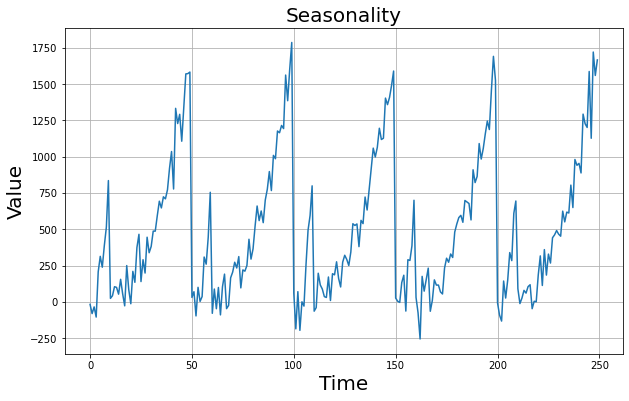

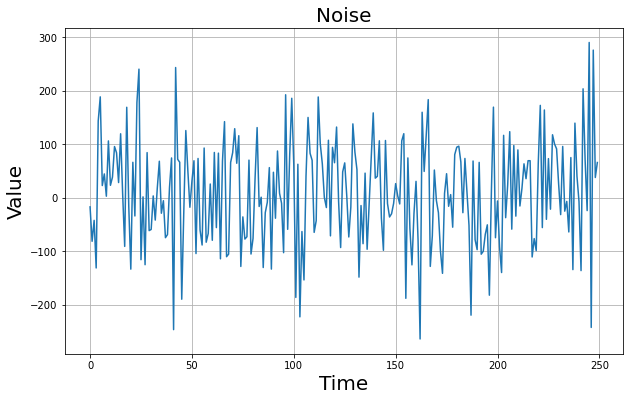

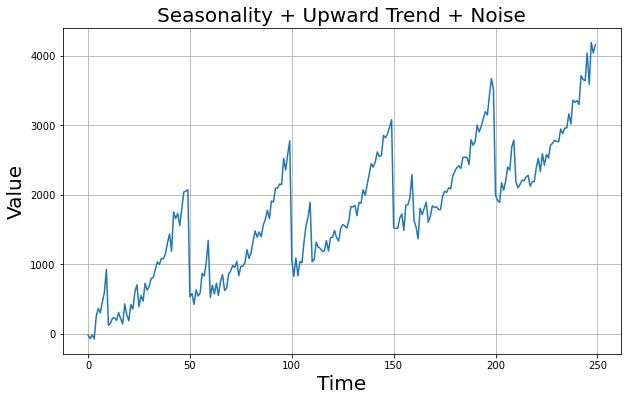

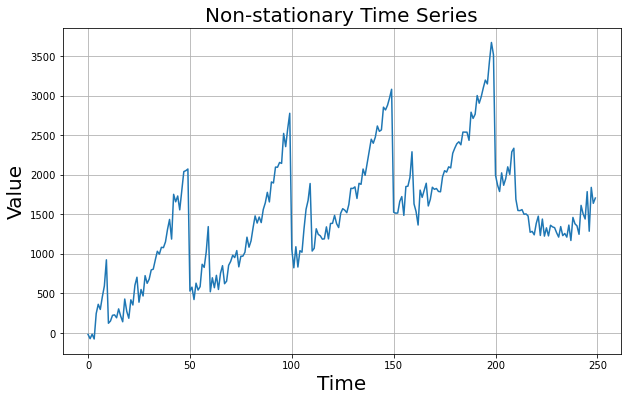

In [212]:
def plot_time_series(time, values, label):
    plt.figure(figsize=(10,6))
    plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)

time = np.arange(100)
values = time*0.4


# Just a random pattern
time = np.arange(50)
values = np.where(time < 10, time**3, (time-9)**2)
# Repeat the pattern 5 times
seasonal = []
for i in range(5):
    for j in range(50):
        seasonal.append(values[j])
# Plot
time_seasonal = np.arange(250)


noise = np.random.randn(250)*100
seasonal_clean = seasonal
seasonal += noise
time_seasonal = np.arange(250)
plot_time_series(time_seasonal, seasonal, label = "Seasonality")

plot_time_series(time_seasonal, noise, label = "Noise")

seasonal_upward = seasonal + np.arange(250)*10
time_seasonal = np.arange(250)
plot_time_series(time_seasonal, seasonal_upward, label="Seasonality + Upward Trend + Noise")


big_event = np.zeros(250)
big_event[-50:] = np.arange(50)*-50
non_stationary = seasonal_upward + big_event
time_seasonal = np.arange(250)
plot_time_series(time_seasonal, non_stationary, label="Non-stationary Time Series")

608.2574500103316
658.2148252248008
199.75859980036392
559.1334820907865
551.4267672576793
98.70009432646424
496.5654081397275
489.3758399625882
79.343138739867


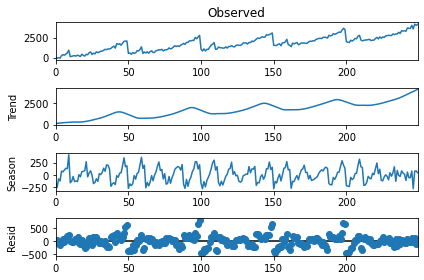

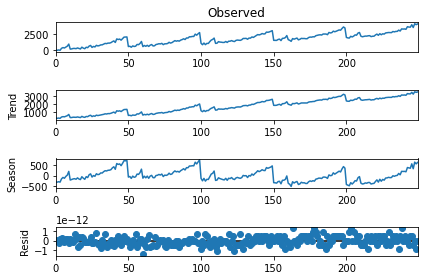

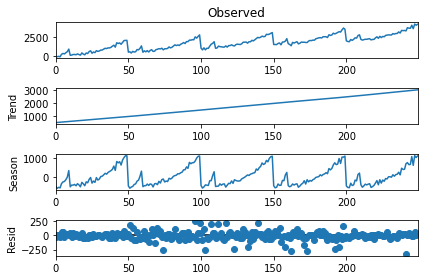

In [214]:
stl = STL(seasonal_upward, period = 12)
res = stl.fit()
fig = res.plot()

trend = np.arange(250)*10
print(rmse(res.trend, trend))
print(rmse(res.seasonal, seasonal_clean))
print(rmse(res.resid, noise))

seasonal_upward = pd.DataFrame(seasonal_upward)
stf = STF_reflected(seasonal_upward, period = 50, window="blackman")
res = stf.fit()
fig = res.plot()

print(rmse(res.trend, trend))
print(rmse(res.seasonal, seasonal_clean))
print(rmse(res.resid, noise))

stl = STL(seasonal_upward, period = 50, robust = True)
res = stl.fit()
fig = res.plot()

trend = np.arange(250)*10
print(rmse(res.trend, trend))
print(rmse(res.seasonal, seasonal_clean))
print(rmse(res.resid, noise))